In [5]:
import pandas as pd
import ms3 
from  ms3.utils import *
import os 
from ms3 import Score
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# include directory 
home_dir = '/home/nulpe/Desktop/Tresillo/'

# Towards a Rhythmical Definition of the Tressilio beat and a Tracing of it in Popular Music 

## 1) Introduction & Research Question 

### 1.1) Research question: 
"Can we compute to which extent a defined rhythm, which we refer to as Tresillo rhythm, is used in a given pop song and if so can we measure the intensity of Tresillo rhythm use in billboard songs over the past twenty years?"  

**Discussion:**  
In our project we would like to discuss the use of a rhythm, which we refer to as 'Tresillo rhythm', in the popular music of the last 20 years. We define this rhythm in our project, given secondary literature, and thus obtain a precise notation and formulization of the Tresillo rhythm. Given this definition we can then compute the similarity between the Tresillo rhythm and the rhythm of a given pop song. Thus, we hope to obtain a similarity coefficient which measures how similar the rythm of a given pop song is to our self defined Tresillo rythm. Given the computed similarity coefficients, we hope to measure the use of the Tresillo rhythm in the top 20 billboard songs of the past 20 years (1999-2019).


### 1.2) Assumptions

### 1.3) Data Representation
Initially our data is represented in the MIDI file format. The representation of music in the MIDI format has the advantage, that often several voices of different instruments are represented in such files. In contrast to musescore, where often only the voice of one instrument (mostly piano) is notated.  
However, to obtain a list of onsets of every musical event in a given song, we have to convert our MIDI (.midi) files to Musescore (.mscx) files.  
To convert and further analyze our files, we will use the [ms3](https://pypi.org/project/ms3/) python library.  
To convert a directory of .midi files to .mscx files we use following command:


In [ ]:
path_midi = '/home/nulpe/Desktop/Tresillo/dataset/project_midi/tresillo/'
target = '/home/nulpe/Desktop/Tresillo/dataset/project_mscx/mscx_tresillos_billboard/'

dir_list = os.listdir(path_midi)

for el in dir_list:
    convert(path_midi+el, target+el[:-4]+'.mscx', MS='musescore3')

Given the Musescore representation, we can now obtain a list of all musical events in a given song. Given additional information about bars and timing of the onsets, this data representation comprises all information we need for our analysis. The code below exemplifies how our final data representation looks like:

In [3]:
dir_mscx = '/home/nulpe/Desktop/Tresillo/dataset/project_mscx/mscx_tresillos_billboard/Shape of you-Ed Sheran.mscx'
s = Score(dir_mscx)
df = s.mscx.notes

df.head(5)

,mc,mn,mc_onset,mn_onset,timesig,staff,voice,duration,nominal_duration,scalar,tied,tpc,midi,volta,chord_id
0,1,1,0,0,4/4,2,1,1/8,1/8,1,<NA>,7,61,<NA>,6
1,1,1,0,0,4/4,6,1,1/8,1/8,1,<NA>,7,61,<NA>,12
2,1,1,0,0,4/4,9,1,1/8,1/8,1,<NA>,7,61,<NA>,18
3,1,1,0,0,4/4,9,1,1/8,1/8,1,<NA>,4,64,<NA>,18
4,1,1,0,0,4/4,2,1,1/8,1/8,1,<NA>,8,68,<NA>,6


**TA instructions**: Precision of Research Question

- State the final version of your research question as you understand it now.

-  Make all assumptions and hypotheses explicit.

- In case Milestone 2 did not include the final data representation that you are analyzing, present the representation you finally used and the necessary steps to get to it.

**Thoughts Aurel:** 
 - Reasearch Question: Move to a fuzzy definition of Tresillio-ness: E.g.: 
    Are pop songs increasingly using a rythm pattern which is similar to a rythm pattern which we reffer to as 'Tresillio rythm'?  
    
 - Assumptions are very important for them. Here we have to note our definition(s) of the Tresillio rythm pattern and how we derive them (incl sources). Furthermore, we have to discuss cases where there are Rythms which are similar to the Tresillio rythm but not equivalent (e.g.: reggaeton) and how we deal with them computationally.  
 
 - Here we have to discuss the conversion of our MIDI files to the musescore3 file format. Furthermore, we have to discuss what the musescore3 format offers us, and why it is the better choice for our analysis. 
 
  **Toughts Florian:**
    -Assumptions:
    
    -30 second piece of pop song is suitable to identfy the main rythm
    
    -Main rythm can be identified by counting the onsets
    
    -the great majority of pop songs comes in 4/4 (not shure if we really need that assumption)
    

## 2) Methods

### 2.1) Definition of the Tresillo rhythm
ToDo Florian (cite relevant literature to define tresillo)

### 2.2) Rhythm histograms and vectors 

To be able to measure the similarity between rhythm we must have a clear definition and thus following representation of rhythm. In general, one can define rhythm as "a series of onsets and durations of musical events.” (Rohrmeier, 2020). In our specific case however, we are interested in the dominat and repeating rhythm of a given song. Therefore we prefer a narrower definition of rhythm as “repeated recurrences in alternate heavy and light beats” (Chin and Wu, 1992). To furthermore simplify our data, we assume that the main rhythm of a song can be defined by the onsets  of its musical events (notes).  
To obtain a representation of the dominate rhythm of a song, we preceed to aggregate all musical onset to one bar. Collapsing all musical onsets to one bar and thus obtaining onset 'histograms' is a common pratice and has been used beside others to analyze western classical music (Palmer and Krumhansl, 1990) and american folk music (Huron and Ommen, 2006). 
With the onset histogram of a song we can compile a n dimensional vector for each song, which we refer to as a 'rhythm vector'. Given that the number of songs with meters other than 4/4 is negible, we only consider songs with a 4/4 meter in our analysis.  Given that we only consider songs with 4/4 meters, we obtain for each song a 16 dimensional vector. 




### 2.3) Naive approach: Rhythm simularity measured with cosine simularity 
Given the 16 dimensional rhythm vectors we obtain following the methode described above, we can now compute simple similarity metrics.  
In rhythm analysis a common similarity metric which is used to calculate the similarity between two rhythm vectors is the cosine distance (see: anteli et al., 2014; Parry and Essa, 2003).  The cosine similarity metric is scale invariante, which as such is interesting for rhythm similarity given that thus only relative frequencies of onsets are important and not absolute frequencies.  
The cosine distance between two vectors A and B is defined as following: 
\begin{equation}
\cos ({\bf A},{\bf B})= {{\bf A}*{\bf B} \over \|{\bf A}\| \|{\bf B}\|} = \frac{ \sum_{i=1}^{n}{{\bf A}_i{\bf B}_i} }{ \sqrt{\sum_{i=1}^{n}{({\bf A}_i)^2}} \sqrt{\sum_{i=1}^{n}{({\bf B}_i)^2}} }
\end{equation}

Given the definition of the cosine similarity we can now compute the similarity between our self defined Tresillo rhythm and the billboard songs.  
First, however we will validate this similarity metric by testing it on our self compiled list of songs which do comprise a Tresillo rhythm and songs which do not comprise a Tresillo rhythm. We then compute the mean 'Tresillo-ness' (similarity to Tresillo rhythm) of both samples. By employing the Bootstrapping method we can also obtain a measurement of uncertainty, as provided by 2.5% and 97.5% confidence intervals.

### 2.4) Reducing noise: (pushkar)

**TA instructions**: 
- How did you deal with the problems you mentioned in Milestone 2?

- Which methods did you use to obtain the final results? Provide self-contained explanations and make sure to cite relevant literature where appropriate.

- Explain your core calculations using equations.

- Do not describe all the methods you tried out but only those that lead to the results: the final analysis is not an exploratory analysis anymore.

- Specify any adjustments you made to pre-existing methods


**Thoughts Aurel**:  
 -  Talk about how we got to the bar representation of our music. Furthermore, also discuss how we get to a 'perfect Tresillio Histogram'
    
 - Here I propose we try out several things and compare the results of several methods:
 
  a) A first big topics is how we define the perfect Tresillo:  
   1. Given predefined rythm patterns (by Florian)
   2. Given songs with high Tresillio-ness
    - All instruments collapsed
    - Only key instruments
    - Certain instruments  
    
  a) The second big question is how do we measure Tresillio-ness in the pop songs, I would suggest three approaches. All aproaches require that we first obtain 16 dimensional Rythm vectors of each song of interest:  
   1. Compare our vanilla self defined Tresillio rythm vector with all vectors of our pop songs. Measure distance or simularity with some commonly used distance measure in the literature
   2. Very similar to 1) but this time use the Tresillio rythm vector as defined by our songs
   3. Prior clustering of the rythm vectors. Obtaining centroid and measuring with it Tresillio ness in the charts (method as proposed by Pushkar)
 
- Equations should be included in the prior part
- Discuss critically any outliers, problems and limitations of our methodology. Extra focus on the question how we deal with related but not the same rythm (e.g.: Reggaeton)


**Toughts Florian**
- Following the last paper discussion one measuurement we could use is the Cosin distance 
- Not sure about an instrument selection. We can mention that a reduction seems not favorable as the tresillo rythm  is presented with different instruments throughout the dataset

## 3) Final Results

### 3.1) Onset histograms and rhythm vectors 
In this first part we will use onset histograms to compute rhythm vectors.  
To obtain the onset histogram of a given song, we use the notes representation provided by the [ms3](https://pypi.org/project/ms3/) libary and colapse all musical onsets to one bar. In the example below we will compile the histograms for our self defined 'Vanilla Tresillo' and for the example song 'shape of you' by Ed Sheran. Then we will proceed to compute the rhythm vectors for both songs

Text(0.5, 1.0, 'Vanilla Tresillo')

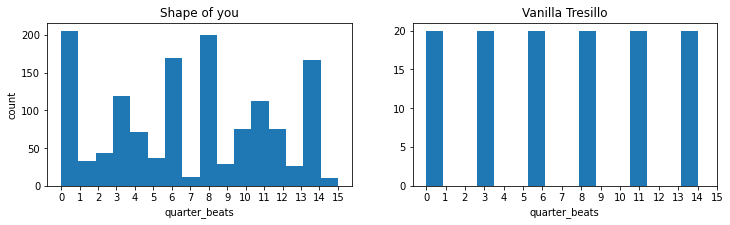

In [30]:
#paths to both examples
shape_of_you = home_dir+'dataset/project_mscx/mscx_tresillos_billboard/Shape of you-Ed Sheran.mscx'
vanilla_tresillo = home_dir+'dataset/project_mscx/mscx_tresillos/Vanilla_Tresillo.mscx'


# get the note scores of both examples 
df_shape_of_you = Score(shape_of_you).mscx.notes
df_vanilla_tresillo = Score(vanilla_tresillo).mscx.notes

#calculate quarter note position for each note
df_shape_of_you['quarter_beats'] = (df_shape_of_you.mc_onset*16).astype('int32')
df_vanilla_tresillo['quarter_beats'] = (df_vanilla_tresillo.mc_onset*16).astype('int32')


fig, ax = plt.subplots(1,2, figsize=(12,3))

ax[0].hist(df_shape_of_you['quarter_beats'], bins=16)
ax[1].hist(df_vanilla_tresillo['quarter_beats'], bins=16)
ax[0].set_xlabel('quarter_beats')
ax[1].set_xlabel('quarter_beats')
ax[0].xaxis.set_ticks(np.arange(0, 16, 1))
ax[1].xaxis.set_ticks(np.arange(0, 16, 1))
ax[0].set_ylabel('count')
ax[0].set_title('Shape of you')
ax[1].set_title('Vanilla Tresillo')

#mention somewhere that we are working with quarter notes 

In a next step we want to compile rhythm of each song given this notion of histograms. E.g: every dimension incorporates the absolute frequency of onsets on one given quarter note. This is done as follows:

In [58]:
rhythm_vector_shape_you = df_shape_of_you.groupby(['quarter_beats'])['mn'].agg(['count'])
rhythm_vector_shape_you  = rhythm_vector_shape_you.reindex(list(range(0,16)),fill_value=0).T
rhythm_vector_shape_you 

quarter_beats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,206,33,44,119,72,37,169,12,200,29,75,112,75,27,167,10


In the assumption that the rhythm vectors of distinct voices within a song might include information we want to preserve, we compiled one rhythm vector per instrument in a song as follows:

In [61]:
# Define instruments 
shape_of_you_score = Score(shape_of_you)
instrument_dict = {}
for key in shape_of_you_score.mscx.metadata['parts']:
    for staff in shape_of_you_score.mscx.metadata['parts'][key].keys():
            instrument_dict[staff] = key


#staff to voice/instruments 
df_shape_of_you['instrument'] = [instrument_dict[el] if el in instrument_dict else 'na' for el in df_shape_of_you.staff]

#compute rhythm vectors per voice
rhythm_vector_shape_you_instruments = df_shape_of_you.groupby(['instrument','quarter_beats'])['mn'].agg(['count'])
rhythm_vector_shape_you_instruments = rhythm_vector_shape_you_instruments.groupby(level=0).apply(lambda x: x.reset_index(level = 0).drop(['instrument'],axis=1).reindex(list(range(0,16)),fill_value=0).T)
rhythm_vector_shape_you_instruments = rhythm_vector_shape_you_instruments.reset_index()
rhythm_vector_shape_you_instruments

quarter_beats,instrument,level_1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Grand Piano,count,66,0,0,0,0,0,0,0,66,0,0,0,0,0,0,0
1,"Marimba, untitled",count,66,0,0,53,14,0,63,0,68,0,0,57,17,0,63,0
2,Melodic Drum,count,0,0,33,36,13,19,39,0,0,0,50,28,10,19,38,0
3,Overdrive Gtr,count,6,2,1,1,4,4,6,2,6,1,6,2,6,1,6,0
4,Percussion,count,24,23,0,2,19,2,22,2,21,21,1,2,19,2,23,2
5,Tenor Sax,count,20,8,10,8,16,12,16,8,16,7,18,6,15,5,14,8
6,Woodblock,count,2,0,0,2,0,0,2,0,2,0,0,1,2,0,2,0
7,Xylophone,count,22,0,0,17,6,0,21,0,21,0,0,16,6,0,21,0


If we want to compile rhythm vectors (per voice) for all mscx files in one directory we can use following loop:

In [ ]:
def rythm_vectors(in_dir, out_dir):
    list_sheet_music = os.listdir(in_dir)
    df_rythm_vectors =[]

    for idx, el in enumerate(list_sheet_music):
        if el[-4:] == 'mscx':

            
            #Get notes with onsets
            s = Score(dir_sheet_music+el)
            df = s.mscx.notes

            # Define instruments 
            instrument_dict = {}
            for key in s.mscx.metadata['parts']:
                for staff in s.mscx.metadata['parts'][key].keys():
                    instrument_dict[staff] = key


            #staff to instruments 
            df['instrument'] = [instrument_dict[el] if el in instrument_dict else 'na' for el in df.staff]


            # define quarter beat 
            df['quarter_beats'] = (df.mc_onset*16).astype('int32')


            #make rythm matrix & data frame
            df_histogram = df.groupby(['instrument','quarter_beats'])['mn'].agg(['count'])
            df_histogram = df_histogram.groupby(level=0).apply(lambda x: x.reset_index(level = 0).drop(['instrument'],axis=1).reindex(list(range(0,16)),fill_value=0).T)
            df_histogram = df_histogram.reset_index()

            df_histogram.insert(loc=0, column='song_artist', value=el[:-5])

            #concat to big rythm vector df
            if len(df_rythm_vectors) == 0: df_rythm_vectors = df_histogram

            df_rythm_vectors = pd.concat([df_rythm_vectors,df_histogram], axis=0)

    df_rythm_vectors.to_csv(out_dir, index = False)

    
dir_sheet_music = home_dir + '/dataset/project_mscx/mscx_billboard/'
out_dir = home_dir + '/dataset/rythm_vectors/rythm_vectors_billboard.csv'
rythm_vectors(dir_sheet_music, out_dir)

**TA instructions**: 
- Present your results in relation to your research question.
- Present them in a logical order that does not have to be the order in which you achieved them.

**Thoughts Aurel:** 
- This will be our big code part. I would propose following order:
 1. Histograms of the self defined Tresillio & critical discussion reasoning
 2. Histogram of the Tresillio as defined by popular songs. This includes variations of taking only some instruments. etc
 3. Comparison of Tresillio Histograms to histograms where we can be sure that there is no Tresillio
 4. Discussion of the clustering method, either k-mean clustering or something we dont have to set the cluster number
 5. Finding Tresillio-ness in the pop charts with all three methods a) Vanilla Tresillio-ness b) Tresillio songs vector c) 
 
    

## 4) Outlook on final interpretation

Points to discuss as stated by TAs: 
- Interpreting your results is the final step that you will do in preparing Milestone 4 (your presentations). Please end your submission by giving a first,preliminary outlook on this final step: what aspects of your results do you find interesting with respect to your hypotheses and previous literature? What do you think might be the main points to elaborate upon in the discussion? 